# CESM-LE mixed layer depth

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['TMXL','XMXL','HMXL']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

#convert from cm to m
ds['HMXL'] = ds.HMXL * 0.01
ds['XMXL'] = ds.XMXL * 0.01
ds['TMXL'] = ds.TMXL * 0.01

TMXL
XMXL
HMXL
CPU times: user 208 ms, sys: 21.9 ms, total: 230 ms
Wall time: 737 ms


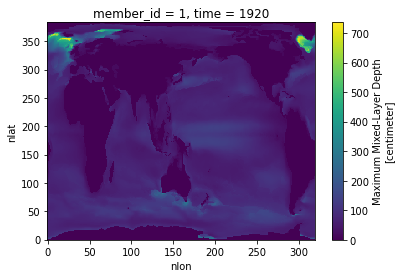

In [3]:
ds['XMXL'].isel(time=0,member_id=0).plot()

### Necessary plotting function

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### get pop grid

In [5]:
grid = pop_tools.get_grid('POP_gx1v6')

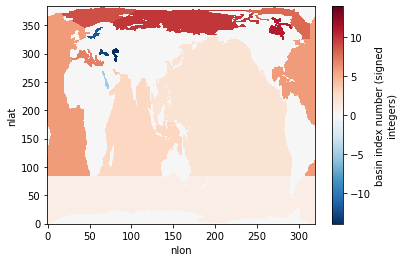

In [6]:
grid.REGION_MASK.plot()

In [7]:
lons = grid.TLONG
lats = grid.TLAT
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [8]:
ds = ds.where(grid.REGION_MASK>0)

### extract 1920s

In [15]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [16]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### extract 1990s

In [9]:
ds.time.isel(time=slice(70,80)).values

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])

In [10]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [11]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [12]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

### calculate ensemble means

In [20]:
ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
ensemble_mean_1990s = ds_1990s.mean(dim='member_id')
ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

## mixed layer depth change

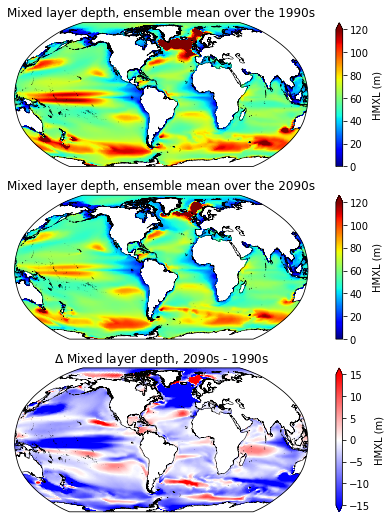

In [14]:
# fig = plt.figure(figsize=(10,9))

# ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
# lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_HMXL_1990s)

# ax.set_title('Mixed layer depth, ensemble mean over the 1990s', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=120,transform=ccrs.PlateCarree())

# cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='HMXL (m)')

# ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
# lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_HMXL_2090s)

# ax.set_title('Mixed layer depth, ensemble mean over the 2090s', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=120,transform=ccrs.PlateCarree())

# cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='HMXL (m)')

# ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
# lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_HMXL_2090s- ensemble_mean_HMXL_1990s)

# ax.set_title('${\Delta}$ Mixed layer depth, 2090s - 1990s', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-15,vmax=15,transform=ccrs.PlateCarree())

# cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='HMXL (m)')

In [15]:
ensemble_mean_XMXL_1990s = ds_1990s.XMXL.mean(dim='member_id')
ensemble_mean_XMXL_2090s = ds_2090s.XMXL.mean(dim='member_id')

In [21]:
# fig = plt.figure(figsize=(10,9))

# ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
# lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_XMXL_1990s)

# ax.set_title('Max mixed layer depth, ensemble mean over the 1990s', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=120,transform=ccrs.PlateCarree())

# cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='XMXL (m)')

# ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
# lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_XMXL_2090s)

# ax.set_title('Max mixed layer depth, ensemble mean over the 2090s', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=120,transform=ccrs.PlateCarree())

# cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='XMXL (m)')

# ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
# lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_XMXL_2090s- ensemble_mean_XMXL_1990s)

# ax.set_title('${\Delta}$ Max mixed layer depth, 2090s - 1990s', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-15,vmax=15,transform=ccrs.PlateCarree())

# cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$XMXL (m)')

## min max layer

In [18]:
ensemble_mean_TMXL_1990s = ds_1990s.TMXL.mean(dim='member_id')
ensemble_mean_TMXL_2090s = ds_2090s.TMXL.mean(dim='member_id')

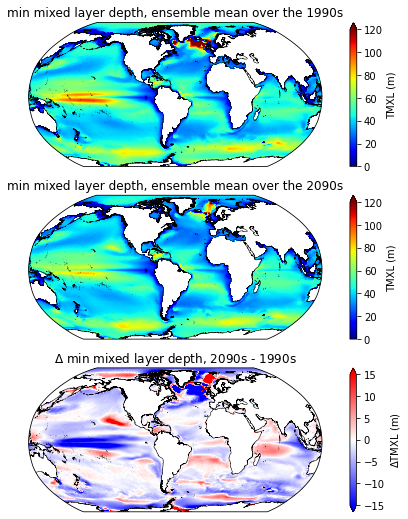

In [19]:
# fig = plt.figure(figsize=(10,9))

# ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
# lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_TMXL_1990s)

# ax.set_title('min mixed layer depth, ensemble mean over the 1990s', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=120,transform=ccrs.PlateCarree())

# cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='TMXL (m)')

# ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
# lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_TMXL_2090s)

# ax.set_title('min mixed layer depth, ensemble mean over the 2090s', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=120,transform=ccrs.PlateCarree())

# cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='TMXL (m)')

# ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
# lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_TMXL_2090s- ensemble_mean_TMXL_1990s)

# ax.set_title('${\Delta}$ min mixed layer depth, 2090s - 1990s', fontsize=12)
# ax.coastlines('10m',linewidth=0.5)
# pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-15,vmax=15,transform=ccrs.PlateCarree())

# cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$TMXL (m)')

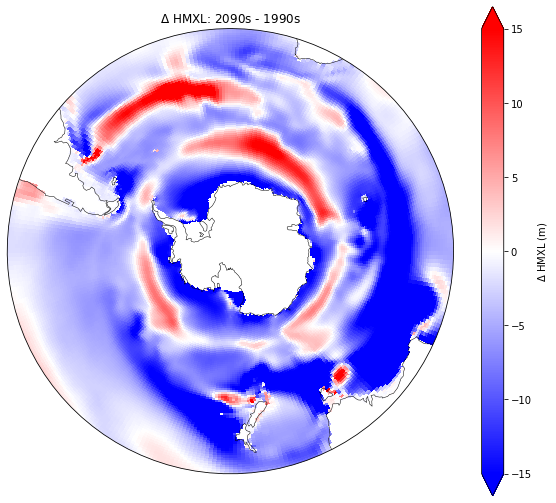

In [18]:
fig = plt.figure(figsize=(10,9))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, (ensemble_mean_HMXL_2090s- ensemble_mean_HMXL_1920s))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('${\Delta}$ HMXL: 2090s - 1990s')
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-15, vmax=15, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ HMXL (m)')


### grab masks for making averages

In [19]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s_v3.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:            (nlat: 384, nlon: 320)
Coordinates:
    TLAT               (nlat, nlon) float64 ...
    TLONG              (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask           (nlat, nlon) float64 ...
    SIZ_mask           (nlat, nlon) float64 ...
    marginal_SIZ_mask  (nlat, nlon) float64 ...

### make ACC timeseries

In [22]:
variables

['TMXL', 'XMXL', 'HMXL']

In [26]:
%%time

ts_ACC = xr.Dataset({v: ds[v] for v in ['time','member_id']})

for v in variables:
    
    masked = ds[v].where(ds_masks.ACC_mask==1.)
    ts_ACC[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

ts_ACC_ensmean = ts_ACC.mean(dim='member_id')

In [24]:
%%time

ts_SIZ = xr.Dataset({v: ds[v] for v in ['time','member_id']})

for v in variables:
    
    masked = ds[v].where(ds_masks.SIZ_mask==1.)
    ts_SIZ[v] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

ts_SIZ_ensmean = ts_SIZ.mean(dim='member_id')

CPU times: user 33.2 s, sys: 1min 8s, total: 1min 41s
Wall time: 3min 48s


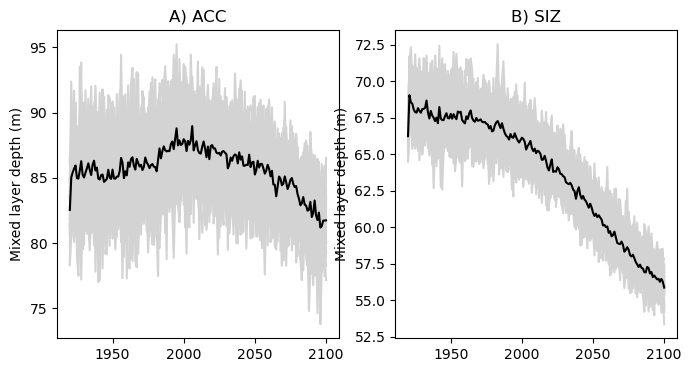

In [29]:
style.use('default')
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
ax[0].set_title('A) ACC')
ax[0].set_ylabel('Mixed layer depth (m)')

for mem in np.arange(0,34,1):

    ax[0].plot(years, 
         ts_ACC['HMXL'].isel(member_id=mem), 
         color='lightgray')

ax[0].plot(years, ts_ACC_ensmean['HMXL'], 
         color='black', label='HMXL');


ax[1].set_title('B) SIZ')
ax[1].set_ylabel('Mixed layer depth (m)')

for mem in np.arange(0,34,1):

    ax[1].plot(years, 
         ts_SIZ['HMXL'].isel(member_id=mem), 
         color='lightgray')

ax[1].plot(years, ts_SIZ_ensmean['HMXL'], 
         color='black', label='HMXL');

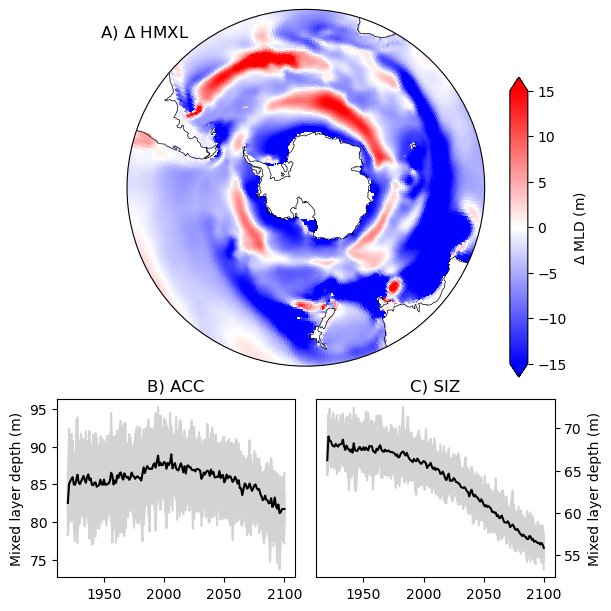

In [55]:
fig = plt.figure(constrained_layout=True,figsize=(6,6))
ax = fig.add_gridspec(3, 2)

#########################################################################################

ax1 = fig.add_subplot(ax[0:2,0:2], projection=ccrs.SouthPolarStereo())
ax1.set_title('A) ${\Delta}$ HMXL',x=0.05,y=0.9)
ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax1.set_boundary(circle, transform=ax1.transAxes)
#################### end circle
lon, lat, field = adjust_pop_grid(lons, lats, (ensemble_mean_HMXL_2090s- ensemble_mean_HMXL_1920s))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]
pc=ax1.pcolormesh(lon, lat, 
                 field, vmin=-15, vmax=15, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax1.coastlines('110m',linewidth=0.5)
# cbar1 = fig.colorbar(pc, ax=ax1,extend='both',label='${\Delta}$ HMXL (m)')
cbar_ax = fig.add_axes([0.84, 0.38, 0.03, 0.5])
cbar1 = fig.colorbar(pc, extend='both', cax=cbar_ax, label='${\Delta}$ MLD (m)');
##############################

ax2 = fig.add_subplot(ax[2,0])
ax2.set_title('B) ACC')
ax2.set_ylabel('Mixed layer depth (m)')

for mem in np.arange(0,34,1):

    ax2.plot(years, 
         ts_ACC['HMXL'].isel(member_id=mem), 
         color='lightgray')

ax2.plot(years, ts_ACC_ensmean['HMXL'], 
         color='black', label='HMXL');
##############

ax3 = fig.add_subplot(ax[2,1])
ax3.set_title('C) SIZ')
ax3.set_ylabel('Mixed layer depth (m)')

for mem in np.arange(0,34,1):

    ax3.plot(years, 
         ts_SIZ['HMXL'].isel(member_id=mem), 
         color='lightgray')

ax3.plot(years, ts_SIZ_ensmean['HMXL'], 
         color='black', label='HMXL')
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right();

fig.savefig('/glade/work/kristenk/figs/MLD_change_figSI.png', bbox_inches='tight', dpi=300, format='png');